# Boundary Conditions

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg

At several places in previous notebooks we have noted opportunities to make the treatment of boundary conditions in Laplace's equation more involved and interesting. This notebook takes up several of these opportunities. Like most of what we've done so far, the lessons learned here apply to a wide range of PDEs, not just to Laplace's equation.

## Functions with Functions as Input

Often a boundary condition is specified as the evaluation of a particular function along the boundary. For this reason, it is quite useful to realize that user-defined Python functions can accept functions as input. To illustrate this I'll take an example from another area. 

Suppose you wanted a Python function that took the numerical derivative of given function, $f(x)$, at a user-defined point $x$. Coding this is much like coding any other user-defined function. Let's suppose that our numerical derivative takes the step size, $h$, the point of evaluation $x$, and the function, $f$, as inputs and returns the numerical derivative at $x$, then we can define it as follows:

In [11]:
def NumD(h,x,f):
    return (f(x+h)-f(x))/h

Notice the two different uses of parentheses here: the outer parentheses in the return statement are the usual grouping of terms, while the inner ones are function evaluation. Python sorts this out because it realizes when the input f is a function. Here are three examples:

In [12]:
def f1(x):
    return x

def f2(x):
    return x**2

def f3(x):
    return np.exp(x)

Let's evaluate their derivatives at the origin:

In [13]:
print(NumD(.1,0,f1))
print(NumD(.1,0,f2))
print(NumD(.1,0,f3))

1.0
0.10000000000000002
1.0517091807564771


And the same examples if we use a 100 times smaller step size:

In [14]:
print(NumD(.001,0,f1))
print(NumD(.001,0,f2))
print(NumD(.001,0,f3))

1.0
0.001
1.0005001667083846


It is a great advantage that we can pass functions to functions. 

<b>Exercise (a)</b> Take the function BndyVals that you defined in the last notebook and modify it so that it takes a user-defined function as input and uses that function to evaluate the boundary conditions along the boundary $y=1$. Call this new function BndyVals1 since it has an arbitrary function along one of its boundaries. (You may also want to call the input function f1, since we are going to have more input functions soon.)

In [17]:
def BndyVals1(Nx,Ny,f1):
    b=np.zeros((Nx-2)*(Ny-2))                            # Initialize all boundary values to zero.
    bndxsFull=np.linspace(0,1,Nx)              #Define x's along top boundary
    bndxsInt=bndxsFull[1:(Nx-1)]
    b[(Nx-2)*(Ny-2)-(Nx-2):(Nx-2)*(Ny-2)]=[f1(x) for x in bndxsInt] #Update boundary V's along top boundary
    return b

## Length Scales

We have noted a couple of times that the refinement of the lattice and the length scales of the space being discretized are independently specified. You can use 100 lattice points along a line of length 1 and you can use 10 lattice points along a line of length 100. Of course, the spacing between lattice points is quite different in these two examples, but the point is that $N_x$ and $\ell_x$ are independent. 

So far the boundary condition we have been using, i.e. at $y=1$ the potential is given by $\sin(\pi x)$, has assumed that $\ell_x=1$. Let's change that now so that the boundary condition takes into account the length scale. 

A feature of this boundary condition was that the sine function vanished at $x=0$ and at $x=1$, which matched the other boundary conditions. How do we retain this feature if the extension in the $x$-direction is $\ell_x$? It's not hard, we simply rescale the argument of the sine function: $\sin(\pi x/\ell_x)$. This again vanishes at $x=0$ and when $x=\ell_x$. However, now the $x$ in the argument of the sine function must have units of length; otherwise we would be taking the sine of something with units, which doesn't make sense. Previously, we noted that we can write any lattice point $x_i$ as $i \Delta x$, with $\Delta x$ the spacing between lattice points. Examining a picture of a lattice, you will note that $\Delta x = \ell_x/(N_x-1)$. Thus, evaluating our boundary value function at $x_i$ gives

$$
\sin(\pi x_i/\ell_x) = \sin(\pi i \Delta x/\ell_x) = \sin(i \pi/(N_x-1)).
$$

(You might worry that this has the wrong value at the rightmost lattice point, but recall that $i$ runs from zero up to $N_x-1$, and so we again get zero at the this point.) It is striking that the length scale built in to the boundary value function and the length scale built into our lattice spacing properly cancelled out. This is a common occurrence in numerical discretizations. 

<b>Exercise (b)</b> Define a function fb1 that properly gives the boundary values, specified above, at $y=1$ for any extension of lattice $\ell_x$. 

## Combining Multiple Boundary Conditions

Up to this point we have always worked with boundary conditions that grounded three plates around the boundary of our pipe. Let's relax this condition. Once we've worked out how to make two boundaries non-vanishing, it's a simple extension to make any number of boundaries non-vanishing.

Going back to the section "The Structure of the Linear Algebra Problem" in the 2DRelaxation notebook, if you worked out the case of one of the corner lattice points, e.g. $V_{3,3}$, you found something like 

$$
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & -1 & 0 & -1 & 4
\end{pmatrix}
\begin{pmatrix}
V_{1,1}\\ V_{2,1} \\ V_{3,1} \\ V_{1,2} \\ V_{2,2} \\ V_{3,2} \\ V_{1,3} \\ V_{2,3} \\ V_{3,3}
\end{pmatrix} = V_{3,4}+V_{4,3}.
$$

This shows that the two boundary values neighboring this corner lattice point add to give the total boundary condition there. This gives a simple way of treating the code: we just add in the contribution of each boundary. For example, given a pipe with boundary value function f1 along the $y=1$ boundary and f2 along the $x=1$ boundary, the following function gives the appropriate boundary condition. 

In [51]:
def BndyVals2(Nx,Ny,f1,f2):
    b=np.zeros((Nx-2)*(Ny-2))             #Initialize the b vector to zero.
    
    bndxsFull=np.linspace(0,1,Nx)         #Define x's along top boundary
    bndysFull=np.linspace(0,1,Ny)         #Define y's along top boundary
    bndxsInt=bndxsFull[1:(Nx-1)]          #Exclude corners
    bndysInt=bndysFull[1:(Ny-1)]
    
    bndValsy=[f2(y) for y in bndysInt]    #Find V along right bndry
    
    #Update boundary V's along top boundary
    b[(Nx-2)*(Ny-2)-(Nx-2):(Nx-2)*(Ny-2)]=[f1(x) for x in bndxsInt] 

    j=(Nx-3)              #Initialize a counter to pick out the right bndry
    for i in range(0,len(bndValsy)):     #Update V's along right bndry
        b[j]=b[j]+bndValsy[i]
        j += (Nx-2)

    return b

In [72]:
def f1(x):
    return np.sin(np.pi*x)
    
def f2(y):
    return 5

In [73]:
BndyVals2(5,5,f1,f2)

array([0.        , 0.        , 5.        , 0.        , 0.        ,
       5.        , 0.70710678, 1.        , 5.70710678])

<b>Exercise (c):</b> Update the BndyVals2 function to a BndyVals4 function that depends on four different input functions, one for each of the four boundaries. For convenience in comparing answers, use the convention that f1 is associated to the top boundary, f2 to the right one, f3 to the bottom, and f4 to the left.

Before closing this section, here is an example of all of the code for a relaxation problem together in one place. 

In [ ]:
def BuildM(Nx,Ny):
    M = np.zeros([(Nx-2)*(Ny-2),(Nx-2)*(Ny-2)])
    for i in range((Nx-2)*(Ny-2)):
        M[i, i] = 4  
        if i > 0:                  # Begin by setting all the neighbors to the diagonals to -1.
            M[i, i-1] = -1         # This assumes that each lattice point has a neighbor to the 
        if i < ((Nx-2)*(Ny-2)-1):  # left and right, which is false and is corrected below.
            M[i, i+1] = -1
        if i > (Nx-3):               #Once you are far enough into the lattice, always include -1
            M[i,i-(Nx-2)] = -1       # for a lattice neighbor below the current site.
        if i < ((Nx-2)*(Ny-2)-(Nx-2)):              #As long you are not too far into the lattice, always include -1
            M[i,i+(Nx-2)] = -1       # for a lattice neighbor above the current site.
    
    for i in range((Nx-2),(Nx-2)*(Ny-2)-(Nx-3)):      #For lattice sites neighboring the left and right boundaries 
        if i%(Nx-2)==0:             #remove the left (or right, respectively) neighbor. 
            M[i,i-1]=0         #Here, the % operator gives the value of i mod 4. Like a clock
            M[i-1,i]=0         # with only 0,1,2,3 on it, it returns 0 for any multiple of 4.
    return M

def BndyVals2(Nx,Ny,f1,f2):
    b=np.zeros((Nx-2)*(Ny-2))             #Initialize the b vector to zero.
    
    bndxsFull=np.linspace(0,1,Nx)         #Define x's along top boundary
    bndysFull=np.linspace(0,1,Ny)         #Define y's along top boundary
    bndxsInt=bndxsFull[1:(Nx-1)]          #Exclude corners
    bndysInt=bndysFull[1:(Ny-1)]
    
    bndValsy=[f2(y) for y in bndysInt]    #Find V along right bndry
    
    #Update boundary V's along top boundary
    b[(Nx-2)*(Ny-2)-(Nx-2):(Nx-2)*(Ny-2)]=[f1(x) for x in bndxsInt] 

    j=(Nx-3)              #Initialize a counter to pick out the right bndry
    for i in range(0,len(bndValsy)):     #Update V's along right bndry
        b[j]=b[j]+bndValsy[i]
        j += (Nx-2)

    return b

def RelaxLaplace(Nx,Ny,f1,f2):
    M=BuildM(Nx,Ny)
    b=BndyVals2(Nx,Ny,f1,f2)
    
    IntVals=linalg.inv(M)@b
    IntValsMat = IntVals.reshape(Ny-2,Nx-2) #In order to recombine with the boundary values and for visualization,
                                  # reshape the solution to agree with the lattice shape.

    VSol = np.zeros([Ny,Nx])     #Combine the solution and boundary values into one output
    VSol[1:Ny-1,1:Nx-1]=IntValsMat
    VSol[Ny-1,1:Nx-1]=b[(Nx-2)*(Ny-2)-(Nx-2):(Nx-2)*(Ny-2)]  
    return VSol

## Making 3D Surface Plots

In [70]:
from mpl_toolkits import mplot3d

The contour plots that we have been using up to this point are great, but sometimes you want a more direct visual sense of how your function changes, and 3D surface plots can be useful for this. The Matplotlib library has built in functions for this purpose as well. Above we have imported the Matplotlib 3D functionality. This works quite similarly to a contour plot, except that you use a $z$-height to display the values of the function that you are plotting. Below I use our standard example from the last few notebook, with three of the walls of the pipe grounded and the last one subject to a sine wave potential.

In [74]:
def f1(x):
    return np.sin(np.pi*x)
    
def f2(y):
    return 0

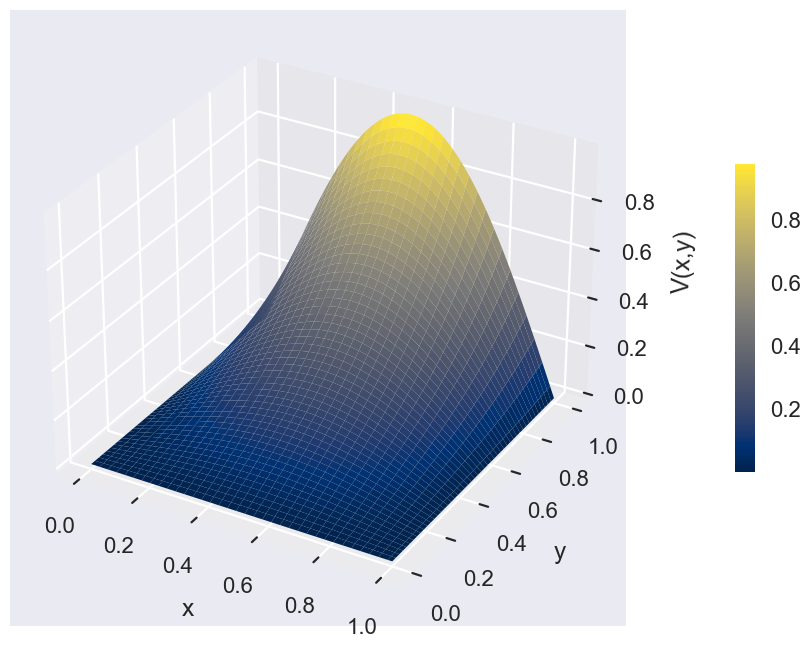

In [83]:
fig = plt.figure(figsize = (28,8))
ax = plt.axes(projection='3d')

X,Y = np.meshgrid(np.linspace(0,1,70),np.linspace(0,1,50))

Z = RelaxLaplace(70,50,f1,f2)

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis) #The last argument specifies the colormap 
                                                       #associated with each function height

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('V(x,y)', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=15) #This adds a colorbar, giving the quantitative 
                                         #correspondence between colors and heights

plt.show()

<b>Exercise (d):</b> Take the case with $f_1(x)=f_3(x)=0$ and $f_2(y)=f_4(y)=1$ and use your new BndyVals4 function to solve Laplace's equation in the pipe numerically. Make the usual contour plot of your solution, but also make a 3D plot along the lines above and compare your result to Griffiths' Fig. 3.21.